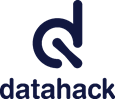

# INTRODUCCIÓN A LOS SISTEMAS DE RECOMENDACIÓN

Autor: [Santiago Moreno Gabaldón](https://www.linkedin.com/in/santiago-moreno-2a19a027/)

Los sistemas de recomendación son modelos cuyo objetivo es proporcionar, como su nombre indica, una recomendación de un producto basada en la experiencia el consumidor o considerando en conjunto la experiencia del consumidor junto con otros consumidores.

Tradicionalmente, los sistemas de recomendación se han basado en la creación de rankings, de modo que se recomienda aquello que más ha votado una comunidad de usuarios.

Gracias a la evolución de los algoritmos de inteligencia artificial, se plantea la posiblidad de aplicar métodos más complejos para la obtención de recomendaciones más precisas y personalizadas.

Así surgen, entre otros, los llamados sistemas colaborativos, que intentan obtener un perfilado o tratar de asignar recomendaciones basadas en perfiles similares.

Entre estos últimos podemos destacar los algoritmos basados en distancias y las descomposiciones matriciales. 

En el ejemplo que se va a desarrollar se va a mostrar un ejemplo tanto de de sistema basado en un ranking genérico y un ejemplo más detallado con un sistema de distancias.

# ANÁLISIS DEL DATASET

Vamos a utilizar un dataset de la plataforma Kaggle que consiste en un conjunto de películas y usuarios los cuales han puntuado entre 0 y 5 las películas que han visto.

Los datos se componen de dos archivos:
- ratings_small.csv con la relación usuario - identificador de película - puntuación
- movies_medatada.csv donde hay información asociada de la película como su nombre y género.

In [213]:
### Carga de librerías genéricas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use("ggplot")
warnings.filterwarnings("ignore")

In [214]:
##Direcciones de los archivos

camino="D:\\J\\Big data\\DATAHACK\\PYTHON\\006-_Caso_segmentacion\\Recomendador peliculas\\"
camino="D:\\0001_11_2016_PERSONAL\\datahack\\0006_Prácticas_master_junio\\"
archivo="ratings_small.csv"
archivo_pelis="movies_metadata.csv"

In [215]:
#Lectura del fichero con los ratings
df=pd.read_csv(camino+archivo)

In [216]:
# Información asociada a las películas
df_info_pelis=pd.read_csv(camino+archivo_pelis)

## ANÁLISIS DE LOS DATAFRAMES

Procedemos a analizar los dos daframes y su estructura, comenzando por el de los rankings

In [217]:
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


El usuaro se identifica con un id, así como la película. El rating es un número, ,una puntuación veremos entre qué valores se mueve. El timestamp no lo vamos a utilizar, con lo que podemos eliminarlo antes de continuar.

In [218]:
df.drop(columns=["timestamp"],inplace=True)

In [219]:
df["rating"].value_counts().sort_index(ascending=False)

5.0    15095
4.5     7723
4.0    28750
3.5    10538
3.0    20064
2.5     4449
2.0     7271
1.5     1687
1.0     3326
0.5     1101
Name: rating, dtype: int64

En efecto, se ve que los ratings van desde 0.5 hasta 5. Veamos cuántos usuarios distintos hay, así como películas:

In [220]:
df["userId"].unique().shape

(671,)

Hay 671 usuarios diferentes

In [221]:
### ESCRIBE TU CÓDIGO AQUÍ PARA OBTENER EL NÚMERO DE PELÍCULAS DISTINTAS

df["movieId"].unique().shape

(9066,)

Hay 9066 películas diferentes puntuadas. Veamos ahora el archivo de las películas:

In [222]:
df_info_pelis.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [223]:
df_info_pelis.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

De todas las columnas nos interesan la que tiene el género de la película, el id para poder cruzar, el título y la media de votos. Filtraomos el df por estos campos.

In [224]:
###TU CÓDIGO PARA QUEDARNOS SOLO CON LAS COLUMNAS:["genres","id","title","vote_average"]
### MODIFICA EL DF df_info_pelis 

df_info_pelis=df_info_pelis[["genres","id","title","vote_average"]]
df_info_pelis.head()

,genres,id,title,vote_average
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,7.7
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,6.9
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,6.5
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,6.1
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,5.7


Antes de seguir, vamos a eliminar nulos. Quitamos cualquier película que no tenga id, o title, o genres o vote_average informado:

In [225]:
df_info_pelis.dropna(how="any",inplace=True,axis=0)

La columna "genres" tiene una estructura un tanto complicada que habría que limpiar

In [226]:
df_info_pelis["genres"][0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

Vemos que una película se puede clasificar de diferentes maneras. Para explotarlo tenemos que ver el tipo de columna:

In [227]:
df_info_pelis["genres"].dtype

dtype('O')

Podemos detectar el género porque se ve que tienen la primera mayúscula. Así podemos filtrar la lista de modo sencillo porque python identifica este formato en textos con el método .istitle()

In [228]:
print("Hola".istitle())
print("hola".istitle())

True
False


La siguiente línea de código crea una nueva columna solo con los géneros:

In [229]:
df_info_pelis["generos"]=df_info_pelis["genres"].apply(lambda x: [y for y in x.split("'") if y.istitle()])
df_info_pelis.head()

,genres,id,title,vote_average,generos
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,7.7,"[Animation, Comedy, Family]"
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,6.9,"[Adventure, Fantasy, Family]"
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,6.5,"[Romance, Comedy]"
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,6.1,"[Comedy, Drama, Romance]"
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,5.7,[Comedy]


Sin embargo, sigue siendo poco manejable, pues el elemento de la columna es un poco "extraño":


In [230]:
##TU CÓDIGO AQUÍ VIENDO EL TIPO DE ELEMENTO DE ESTA COLUMNA.
## AQUÍ DTYPE NO VA A FUNCIONAR PORQUE TE VA A DEVOLVER ALGO GENÉRICCO TIPO OBJECT.
## SACA UN ELEMENTO DE LA COLUMNA Y UTILIZA type

type(df_info_pelis["generos"][0])

list

Tenemos listas que habría que explotar, pues parece que es compatible que una película sea de animación y de aventuras a la vez, pero ¿cuántos es el máximo número de géneros para una sola película?

In [231]:
np.max(df_info_pelis["generos"].apply(lambda x: len(x)))

8

En efecto, se ve que hay hasta 8 géneros distintos para una sola película. La siguiente línea de código nos va a indicar cuántos distintos hay:

In [232]:
set([y for x in df_info_pelis["generos"].values for y in x])

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'War',
 'Western'}

La idea ahora es crear una lista con los que entedamos que son principales y después quedarnos solo con el primero. Crearemos una categría nueva con "otros" para los que no sean de ningún tipo. Sin embargo, antes vamos a limpiar el dataframe eliminando aquellas películas que no tienen ningún género asociado. La línea siguiente es la que lo hace:

In [233]:
df_info_pelis=df_info_pelis[df_info_pelis["generos"].apply(lambda x: bool(x))]

Ahora creamos la columna "genero" con el seleccionado. En la variable nivel_1 metemos los géneros que queremos conservar.
Vamos a quedarnos solo con el primer género de los anteriores que encuentre en cada película

In [234]:
nivel_1=["Action","Animation","Adventure","Comedy",'Crime','Documentary','Fantasy','Music','Horror','Mystery','Romance','Science Fiction','Thriller','War','Western',"History","Drama"]
def saca_genero(x):
    ##Esta función comprueba si existe al menos una categoría de nivel 1 y devuelve la primera que encuentra
    if bool([y for y in x if y in nivel_1]):
        return [y for y in x if y in nivel_1][0]
    else:
        return "Otros"
    
df_info_pelis["genero"]=df_info_pelis["generos"].apply(lambda x: saca_genero(x))
df_info_pelis.head()

,genres,id,title,vote_average,generos,genero
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,7.7,"[Animation, Comedy, Family]",Animation
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,6.9,"[Adventure, Fantasy, Family]",Adventure
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,6.5,"[Romance, Comedy]",Romance
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,6.1,"[Comedy, Drama, Romance]",Comedy
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,5.7,[Comedy],Comedy


¿Cuántos hay en cada tipo?

In [235]:
###Escribe a tu código. Utiliza value_counts() en la columna:

df_info_pelis["genero"].value_counts()

Drama              12197
Comedy              8965
Action              4536
Documentary         3440
Horror              2658
Crime               1716
Thriller            1692
Adventure           1569
Romance             1234
Animation           1231
Fantasy              790
Science Fiction      671
Mystery              564
Music                499
Western              459
War                  381
History              283
Otros                126
Name: genero, dtype: int64

En principio nos vamos a quedar con esta clasificación. Se podría plantear el tener distintos niveles de clasificación tipo género, subgénero e ir clasificando (segmentando) de este modo las películas. Sin embargo, por simplicidad del ejercicio, vamos a dejar un único tipo de género.

Con lo que tenemos ya podemos hablar de un recomendador "tradicional". Tenemos para cada género la película más valorada. Así, con una simple pregunta del género que quiere ver el consumidor, ya podemos recomendarle la película con más nota.

In [236]:
###ESCRIBE AQUÍ TU CÓDIGO PARA VER CÓMO HA QUEDADO EL DF DE FAMILIA:

df_info_pelis.head()


,genres,id,title,vote_average,generos,genero
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,7.7,"[Animation, Comedy, Family]",Animation
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,6.9,"[Adventure, Fantasy, Family]",Adventure
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,6.5,"[Romance, Comedy]",Romance
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,6.1,"[Comedy, Drama, Romance]",Comedy
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,5.7,[Comedy],Comedy


Aun quedan bastantes campos que hemos utilizado para limpiarlo. Vamos a quedarnos solo con los campos ["id","title","vote_average","genero"]

In [237]:
#####AQUÍ TU CÓDIGO. ELIMINA LAS COLUMNAS SOBRANTES O, MÁS FÁCIL, QUÉDATE SOLO CON LAS DE LA LISTA EN EL DF df_info_pelis:
df_info_pelis=df_info_pelis[ ["id","title","vote_average","genero"]]
df_info_pelis.head()


,id,title,vote_average,genero
0,862,Toy Story,7.7,Animation
1,8844,Jumanji,6.9,Adventure
2,15602,Grumpier Old Men,6.5,Romance
3,31357,Waiting to Exhale,6.1,Comedy
4,11862,Father of the Bride Part II,5.7,Comedy


## RECOMENDADOR POR GÉNERO
### RECOMENDADOR "FRESH START"

Ahora podemos ver para cada género seleccionado cuál es la película con más puntuación. Veamos por ejemplo para el género Comedy:

In [238]:
genero_pelicula="Comedy"
np.max(df_info_pelis[df_info_pelis["genero"]==genero_pelicula])


id                 99977
title           ファンタスティポ
vote_average          10
genero            Comedy
dtype: object

Curioso título... difícil de descifrar. Sin embargo, podemos crear una función que, dado el género nos devuelva la película a recomendar:


In [239]:
def recomienda_por_genero(x,dff=df_info_pelis):
    ###Recibe el género de la película y devuelve la serie con el máximo:
    
    return np.max(dff[dff["genero"]==x])
  
    
    

Si buscamos otros géneros, como por ejemplo "War" se aprecia cómo seguimos teniendo títulos en otros idiomas así como puntuaciones sorprendentemente altas:

In [240]:
###TU CÓDIGO: UTILIZA LA FUNCIÓN  PARA EL GÉNERO "War". Recuerda que tienes que pasarlo como string.
recomienda_por_genero("War")

id                                99324
title           Крепость: щитом и мечом
vote_average                         10
genero                              War
dtype: object

Parece razonable por tanto, seleccionar los 5 primeros del género. Creamos una función distinta para elo:

In [241]:
def recomienda_por_genero2(x,y=5,dff=df_info_pelis):
    ###Recibe el género de la película y devuelve la serie con un número y de mejores, 5 por defecto:
    
    return dff[dff["genero"]==x].sort_values(by=["vote_average"],axis=0,ascending=False).iloc[0:y,:]
  

In [242]:
recomienda_por_genero2("War")

,id,title,vote_average,genero
34112,341201,Great Transport,10.0,War
41695,365544,Крепость: щитом и мечом,10.0,War
37330,49099,Images of a Relief,10.0,War
43977,36264,The Deserters,9.0,War
18777,158068,Admiral Yamamoto,8.8,War


Esto tiene mejor pinta. Consulta los valores para el género "Comedy":

In [243]:
### TU CÓDUGO AQUÍ
recomienda_por_genero2("Comedy")


,id,title,vote_average,genero
37582,131907,God is on Air,10.0,Comedy
42733,342546,Nick Swardson: Taste It,10.0,Comedy
27628,180954,Vessel of Wrath,10.0,Comedy
42628,415735,Sebastian Maniscalco: Why Would You Do That?,10.0,Comedy
42614,390991,Frankie Boyle: Hurt Like You've Never Been Loved,10.0,Comedy


### RECOMENDADOR PERSONALIZADO

El recomendador anterior nos sirve para personas de las que no tenemos información, pero sería un poco sorprendente recomendar películas que ya ha visto a un cliente conocido.

Para esto, necesitamos combinar ambos dataframes:df y df_info_pelis

In [244]:
###TU CÓDIGO AQUÍ. HAZ UN .head() de df para recordar los campos que tiene
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


Vamos a considerar al usuario 475. Veamos las películas que ha visto:

In [245]:
##TU CÓDIGO AQUÍ: FILTRA EL DF df POR userId==475 para ver qué contiene
df[df["userId"]==475]

,userId,movieId,rating
68201,475,1,4.5
68202,475,16,4.0
68203,475,47,4.0
68204,475,110,4.0
68205,475,111,4.5
...,...,...,...
68851,475,136020,2.0
68852,475,139644,3.0
68853,475,142488,5.0
68854,475,146656,4.5


Este usuario ha visto 665 películas. Es probable que en las recomendaciones pueda saltar alguna que haya visto. Vamos por tanto a eliminar aquellas películas que haya visto al hacer la recomendación

In [246]:
###Obtenemos un array de numpy con los ids de las películas
pelis_vistas=df[df["userId"]==475]["movieId"].values
pelis_vistas[0:10]

array([  1,  16,  47, 110, 111, 153, 260, 296, 316, 356], dtype=int64)

Antes de hacer los cruces, es recomendable que ambos datos sean del mismo tipo. En elc aso de arriba se ve que el tipo es dtype=int64, es decir, enteros. Veamos el caso de iD del dataframe de info_pelis:

In [247]:
df_info_pelis["id"].dtype

dtype('O')

dtype('O') significa que es un objeto, es decir, string o cualquier otra cosa. Veamos el primer dato de df_info_pelis["id"]

In [248]:
df_info_pelis["id"][0]

'862'

Es 862. Sin embargo, la equivalencia siguiente:

In [249]:
df_info_pelis["id"][0]==862

False

devuelve False. En cambio:

In [250]:
df_info_pelis["id"][0]=="862"

True

Devuelve True. Tenemos que convertir, bien los ids de películas de df_info_pelis a enteros o los movieId de df a string. En teoría, es preferible siempre al tipo más "ligero". Es más fácil cruzar números que textos. Convertimos la columna "id":

In [251]:
df_info_pelis["id"]=df_info_pelis["id"].astype("int64")
df_info_pelis["id"].dtype

dtype('int64')

Ahora ya podemos cruzar ambos dfs por el campo id consiguiendo así sugerir películas que no hay visto antes el usuario

In [252]:
df_info_pelis[(~df_info_pelis["id"].isin(pelis_vistas))].head() ### El símbolo ~ cambia el senido de la recomendación.

,id,title,vote_average,genero
0,862,Toy Story,7.7,Animation
1,8844,Jumanji,6.9,Adventure
2,15602,Grumpier Old Men,6.5,Romance
3,31357,Waiting to Exhale,6.1,Comedy
4,11862,Father of the Bride Part II,5.7,Comedy


Vemos por ejemplo, que nuestro usuario 475 no ha visto la película Toy Story. Podemos utilizar la función anterior para ver qué películas de animiación le recomendamos. Es importante aquí pasar el df filtrado anterior correctamente como parámetro a la función:

In [253]:
recomienda_por_genero2(x="Animation",dff=df_info_pelis[(~df_info_pelis["id"].isin(pelis_vistas))])

,id,title,vote_average,genero
25689,153936,Back to School with Franklin,10.0,Animation
27565,53543,Claymation Comedy of Horrors,10.0,Animation
45371,460135,LEGO DC Super Hero Girls: Brain Drain,10.0,Animation
42155,362585,Kizumonogatari Part 3: Reiketsu,9.4,Animation
45172,351423,Dock Ellis & The LSD No-No,9.0,Animation


Esto completaría los pasos a seguir. No obstante, vamos a crear una función que resuma todo lo que hemos hecho hasta ahora:

    1) Se selecciona un usuario y un género de películas a recomendar;
    2) Se obtiene un dataframe con las películas que el espectador no haya visto;
    3) Se llama a la función que devuelve la recomendación ordenadas por puntuación.


In [254]:
def recomienda_final(id_usuario,id_genero,total_pelis=5,df3=df,df_pelis=df_info_pelis):
    """Función que recibe el usuario y el género y devuelve las películas recomendadas:
    Entradas:
    id_usuario: Usuario a recomendar
    id_genero: Género a recomendar
    total_pelis: Número total de películas a recomendar: por defecto 5
    df3: df con la información de las películas que ha visto el usuario
    df_pelis: df con la información de las películas
    Salida;:
    df con las películas recomendadas y la media de puntuación
    """
    ###Creamos el filtro:
    pelis_filtradas=df[df["userId"]==id_usuario]["movieId"].values
    df_filtrado=df_pelis[(~df_pelis["id"].isin(pelis_filtradas))]
    ###Llamamos a la función que devuelve la redomendación:
    return recomienda_por_genero2(x=id_genero,dff=df_filtrado,y=total_pelis)

In [255]:
recomienda_final(862,"Animation")

,id,title,vote_average,genero
25689,153936,Back to School with Franklin,10.0,Animation
45371,460135,LEGO DC Super Hero Girls: Brain Drain,10.0,Animation
27565,53543,Claymation Comedy of Horrors,10.0,Animation
42155,362585,Kizumonogatari Part 3: Reiketsu,9.4,Animation
45172,351423,Dock Ellis & The LSD No-No,9.0,Animation


Probemos ahora a recomendarle 10 películas de animación:

In [256]:
recomienda_final(862,"Animation",total_pelis=10)

,id,title,vote_average,genero
25689,153936,Back to School with Franklin,10.0,Animation
45371,460135,LEGO DC Super Hero Girls: Brain Drain,10.0,Animation
27565,53543,Claymation Comedy of Horrors,10.0,Animation
42155,362585,Kizumonogatari Part 3: Reiketsu,9.4,Animation
45172,351423,Dock Ellis & The LSD No-No,9.0,Animation
44367,193216,Travels of an Ant,9.0,Animation
44573,448879,Приключения Домовёнка,9.0,Animation
32884,46963,The Grinch Grinches the Cat in the Hat,9.0,Animation
42109,362584,Kizumonogatari Part 2: Nekketsu,8.9,Animation
34695,84774,Alice in Wonderland,8.7,Animation


# RECOMENDADOR COLABORATIVO

Para este recomendador vamos a utilizar las calificaciones a las películas de cada uno de los usuarios e intentar utilizarlas para las recomendaciones. ¿Cómo? La hipótesis es que si alguien puntúa de forma similar las mismas películas que yo he visto, parece plausible que aquellas películas que esta otra persona haya puntuado bien y yo no haya visto, me gusten. 

El modelo que vamos a utilizar se basa precisamente en eso: Vamos a crear una matriz de distancias entre todos los espectadores y calcular la distancia entre ellos. Aquí, la clave está en cómo definir la distancia. Para ello, se generan vectores asociados a cada espectador consistente en las calificaciones con las películas que hayan visto y vacío en las que no.

Una vez que tenemos los vectores, existen medidas de distancias para encontrar los más próximos entre sí. En este sentido, una de las más habituales es la similitud del coseno, que responda a esta expresión:


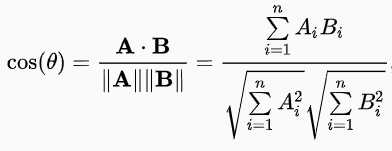

En definitiva, se basa en que podemos interpretar la distancia entre dos vectores como el valor del ángulo que forman. El coseno es muy fácil de calcular con la definición de producto escalar, tal y como se muestra arriba. Un valor de 1 significa que el ángulo entre ellos es 0, es decir, coincidentes. A medida que los vectores se van separando, el valor del coseno va disminuyendo, anulándose cuando son perpendiculares.

Veamos cómo se lleva a cabo esto en python.

Partimos del dataframe df:

In [257]:
###AQUÍ TU CÓDIGO. HAZ UN .head() A df

df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


En el df tenemos el usuario, el id asociado a la película y la calificación. De esta manera, no podemos calcular la distancia. Tenemos que tener una fila por usuario, por columnas todas las películas y como valores las calificaciones.

Esta operación es pivotar la tabla:

In [258]:
df_entrenar=pd.pivot_table(data=df,values="rating",index="userId",columns="movieId")

df_entrenar.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Veamos las dimensiones completas de la tabla:

In [259]:
###TU CÓDIGO AQUÍ: OBTÉN LAS DIMENSIONES DE df_entrenar con .shape

df_entrenar.shape

(671, 9066)

Veamos ahora si coinciden con el original:

In [260]:
###Calculamos el número de espectadores diferentes en df:

len(df["userId"].unique())

671

In [261]:
###TU CÓDIGO AQUÍ. REPITE EL PROCESO ANTERIOR PARA VER EL NÚMERO DE PELÍCULAS DIFERENTES

len(df["movieId"].unique())

9066

En efecto, podemos ver cómo en origen había 671 espectadores y 9066 clientes. Ahora vamos a importar de sklearn una función, cosine_similarity que nos va a permitir calcular la distancia del coseno

In [262]:

from sklearn.metrics.pairwise import  cosine_similarity

Antes de calcular la matriz de distancias, tenemos que eliminar un problema. La función cosine_similarity no permite tratar Nans o datos vacíos y en la matriz pivotada, por columnas tenemos todas las películas que alguien ha visto al menos una vez. Por defecto, la tabla pivotada tiene nans en aquellas películas que no han visto. Tenemos que rellenarlas con algún valor. A este proceso se llama técnicamente imputar. 

Vamos a imputar el valor -1 para imponer una distancia mayor entre las películas no vistas que frente a una baja calificación y así distinguir calificaciones de 0 frente a un no visto:

In [263]:
df_entrenar2=df_entrenar.fillna(-1)

In [264]:
df_entrenar2.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [265]:
distancias=cosine_similarity(df_entrenar2)

Veamos qué nos devuelve:

In [266]:
distancias

array([[1.        , 0.90381398, 0.92835731, ..., 0.94932236, 0.94523956,
        0.84837778],
       [0.90381398, 1.        , 0.88060167, ..., 0.88399394, 0.89912764,
        0.80938996],
       [0.92835731, 0.88060167, 1.        , ..., 0.9122513 , 0.91653054,
        0.83726247],
       ...,
       [0.94932236, 0.88399394, 0.9122513 , ..., 1.        , 0.92465118,
        0.83655594],
       [0.94523956, 0.89912764, 0.91653054, ..., 0.92465118, 1.        ,
        0.85711965],
       [0.84837778, 0.80938996, 0.83726247, ..., 0.83655594, 0.85711965,
        1.        ]])

In [267]:
distancias.shape

(671, 671)

Es un array simétrico y cuadrado de 671x671. Al final la posición i,j nos devuelve la distancia entre los espectadores i y j. Es interesante comprobar cómo en la diagonal principal hay 1. Esto es porque cada espectador coincide consigo mismo, su distancia es 0. Veamos por ejemplo las distancias para el espectador 475

In [268]:
distancias[474] ###Como python indexa desde 0, tenemos que poner siempre uno menos en los índices

array([ 0.56869566,  0.54175221,  0.58061881,  0.45972407,  0.5581868 ,
        0.57287951,  0.5536212 ,  0.56864062,  0.5548769 ,  0.5577906 ,
        0.57414441,  0.55285461,  0.59321196,  0.5808279 ,  0.36450918,
        0.56672475,  0.43009219,  0.54659574,  0.39226377,  0.55288119,
        0.51590441,  0.58008276,  0.34581068,  0.57208107,  0.56425768,
        0.59697015,  0.57003928,  0.5436347 ,  0.57796214,  0.18856915,
        0.59233462,  0.55879841,  0.50763018,  0.49192573,  0.56892594,
        0.51955688,  0.55898718,  0.54821032,  0.54366639,  0.6126428 ,
        0.49557229,  0.62967486,  0.53756853,  0.56527711,  0.56461225,
        0.57205862,  0.56062357,  0.54334484,  0.51908169,  0.56281485,
        0.55359948,  0.5417649 ,  0.56075412,  0.58189149,  0.55354158,
        0.5077354 ,  0.45350724,  0.53586252,  0.57532216,  0.55164375,
        0.57364787,  0.62200087,  0.56336881,  0.57030735,  0.56675437,
        0.57421209,  0.52337259,  0.56990639,  0.55654888,  0.50

El modo de recomendar es buscar aquel más cercano de acuerdo con la matriz anterior, pero ¿qué pasa si buscamos el máximo?

In [269]:
np.max(distancias[474])

0.9999999999999987

In [270]:
np.argmax(distancias[474])

474

El valor de la diagonal principal es donde está el máximo. Para evitar que recomendemos a un espectador las películas que ya haya visto, vamos a cambiar los valores de la diagonal principal por valores de -1. Lo bueno de numpy es que tiene un método para casi todo:

In [271]:
np.fill_diagonal(distancias,-1)


Además, podría darse el caso de que hubiera dos espectadores con las mismas puntuaciones para las mismas películas. Vamos a definir un umbral a partir del cual vamos a redondear también a -1

In [272]:
umbral=0.9999
distancias=np.where(distancias>=umbral,-1,distancias)

Ya tenemos nuestra matriz de distancias lista para ser usada. Veamos ahora cómo extraer los n mayores. Para ello, vamos a utilizar el método argpartition. Este crea una partición que separa el array en dos grupos, dejando al principio los índices de los enésimos valores menores y a la derecha los mayores.

Veamos como funciona con un ejemplo sencillo:



In [273]:
array_prueba=np.array([1,6,7,4,5,8,2])
print(np.argpartition(array_prueba,2))
print(array_prueba[np.argpartition(array_prueba,2)])

[0 6 3 2 4 5 1]
[1 2 4 7 5 8 6]


En el ejemplo de arriba nos ha devuelto en las primeras posiciones los índices 0 y 6 que equivalen a los valores 1 y 2 que son los dos más pequeños

In [274]:
print(np.argpartition(array_prueba,4))
print(array_prueba[np.argpartition(array_prueba,4)])

[0 6 3 4 1 2 5]
[1 2 4 5 6 7 8]


Ahora nos ha dejado las posicioens 0,6,3 y 4 que son respectivamente el 1,2,4 y el 5, los cuatro valores menores.

Vamos a utilizar índices negativos que lo que van a hacer es situar los enésimos valores mayores al fina:

In [275]:
print(np.argpartition(array_prueba,-4))
print(array_prueba[np.argpartition(array_prueba,-4)])

[0 6 3 4 1 5 2]
[1 2 4 5 6 8 7]


Así, para obtener las 5 posiciones mayores en el array de distancias tenemos que hacer esto:

In [276]:
np.argpartition(distancias[474],-5)[-5:]

array([ 83, 614, 315,  71, 552], dtype=int64)

Finalmente, solo quedaría sumar 1 dado que los índices en python empiezan desde 0 y así tendríamos ya los mismos ids que en los dfs:

In [277]:
np.argpartition(distancias[474],-5)[-5:]+1

array([ 84, 615, 316,  72, 553], dtype=int64)

Creamos una función que nos los devuelva automáticamente ya adaptada a los ids de clientes reales, no los índices de python:

In [278]:
def devuelve_similares(indice,total_similares=5,distancias=distancias):
    return np.argpartition(distancias[indice-1],-total_similares)[-total_similares:]+1

Metamos, por ejemplo, al consumidor número 475:

In [279]:
similares_475=devuelve_similares(indice=475)

In [280]:
similares_475

array([ 84, 615, 316,  72, 553], dtype=int64)

En efecto, coincide con los hemos calculado antes. Veamos ahora las películas que le gustan a nuestro 475:

In [281]:
df_puntuaciones_475=df[df["userId"]==475][["movieId","rating","userId"]]
df_puntuaciones_475

,movieId,rating,userId
68201,1,4.5,475
68202,16,4.0,475
68203,47,4.0,475
68204,110,4.0,475
68205,111,4.5,475
...,...,...,...
68851,136020,2.0,475
68852,139644,3.0,475
68853,142488,5.0,475
68854,146656,4.5,475


Tiene puntuadas 655 películas. Todo un cinéfilo. Podemos identificar las películas que existen en la base de datos tomando los ids de arriba y filtrando nuestro dataframe df_info_pelis que contiene la información de las películas:

In [282]:
df_info_pelis[df_info_pelis["id"].isin(df[df["userId"]==475]["movieId"].values)]

,id,title,vote_average,genero
221,8984,Disclosure,5.9,Drama
302,110,Three Colors: Red,7.8,Drama
534,858,Sleepless in Seattle,6.5,Comedy
694,8866,The Truth About Cats & Dogs,5.7,Comedy
938,260,The 39 Steps,7.4,Action
...,...,...,...,...
40578,72733,Bangkok Traffic Love Story,7.4,Comedy
42810,4369,Just a Question of Love,7.5,Drama
43368,48780,Boat,7.6,Otros
44066,62999,From 180 & Taller,3.2,Comedy


De las 655 anteriores, solo cruzan 150. El siguiente paso lógico podría ser obtener las películas que han visto los espectadores que nuestra matriz ha detectado como similares al 475. Estos estaban en un array de índice 475:

In [283]:
similares_475

array([ 84, 615, 316,  72, 553], dtype=int64)

In [284]:
###Las del usuario 316:

In [285]:
df_info_pelis[df_info_pelis["id"].isin(df[df["userId"]==316]["movieId"].values)]

,id,title,vote_average,genero
221,8984,Disclosure,5.9,Drama
938,260,The 39 Steps,7.4,Action
1498,8874,My Best Friend's Wedding,6.4,Comedy
1595,4995,Boogie Nights,7.5,Drama
2065,4011,Beetlejuice,7.1,Fantasy
2531,30793,House of Dracula,5.8,Horror
2719,6373,The Very Thought of You,5.0,Comedy
3210,4816,Ghost Dog: The Way of the Samurai,7.2,Crime
3382,593,Solaris,7.7,Drama
3556,541,The Man with the Golden Arm,6.9,Crime


Veamos ahora todos:

In [286]:
df_info_pelis[df_info_pelis["id"].isin(df[df["userId"].isin(similares_475)]["movieId"].values)]

,id,title,vote_average,genero
221,8984,Disclosure,5.9,Drama
286,527,Once Were Warriors,7.6,Drama
302,110,Three Colors: Red,7.8,Drama
474,6,Judgment Night,6.4,Action
534,858,Sleepless in Seattle,6.5,Comedy
...,...,...,...,...
40113,2324,Local Color,6.1,Drama
43368,48780,Boat,7.6,Otros
44144,68954,Longitude,7.3,Drama
44477,86190,Adventures Of A Taxi Driver,6.8,Comedy


Pues parece que los 5 espectadores más similares tienen hasta 164 películas.  Vamos a sistematizar los distintos pasos en funciones para que sea más sencillo. Pasos: Dado un id de usuario:

    1) Se obtienen los espectadores "similares" a este espectador;
    2) Obtenemos las películas que ha visto el espectador;
    3) Obtenemos las películas que han visto los espectadores similares y las añadimos a las que ha visto nuestro espectador;

En estos puntos anteriores habrá cosas que se podrán configurar:

    a) El número de espectadores similares con quienes comparar;
    b) La puntuación mínima que un espectador similar pone para que una película sea recomendada o no;
    c) obtener la salida solo con las películas que el espectador ha visto o solo las recomendadas.

In [287]:


##Función que obtiene las películas para un índice de espectador en concreto:
def filtro_por_Id(indice,df_info_pelis=df_info_pelis,df=df):
    """Función que obtiene las películas para un índice de espectador en concreto:
       Entradas:
       - indice: el nombre (índice) del usuario del que vamos a obtener las películas que ha visto
       - df_info_pelis: Dataframe con toda la información relativa a las películas.
       - df :Dataframe con las películas que ha visto cada usuario en concreto
        Salida:
        - Dataframe con el título y el id de películas que ha visto el usuario "indice"
        """
    return df_info_pelis[df_info_pelis["id"].isin(df[df["userId"]==indice]["movieId"].values)][["title","id"]]

##Función para añadir al filtrado las puntuaciones. El valor de limitando indica
## si hay que limitar puntuaciones. Esta función internamnete llamará a la de arriba:

def anade_puntuaciones(indice,df=df,limitando = 0):
    """Función para añadir al filtrado las puntuaciones.
    Obtiene los ids y ratings del propio espectador de las películas que ha visto el espectador
    y añade los títulos. Además, permite filtrar por el valor de las puntuaciones
    Entradas:
    - indice:el nombre (índice) del usuario del que vamos a obtener las películas que ha visto y sus calificaciones
    - df: Dataframe con la películas que ha visto cada usuario en concreto
    - limitando: valor de la puntuación por el que se quiere filtrar. Si limitando =4 solo aparecerán películas con puntuaciones
    superiores o iguales a 4
    Salida:
    df con las películas que ha visto el usuario, sus títulos y las calificaciones que ese usuario ha puesto"""
    df_salida=df[df["userId"]==indice][["movieId","rating"]]
    df_salida=filtro_por_Id(indice=indice).merge(df_salida,left_on="id", right_on="movieId")[["title","id","rating"]]
    df_salida=df_salida[df_salida["rating"]>=limitando]
    df_salida["indice"]=indice
    return df_salida

##Replicamos aquí la función que obtiene los más cercanos:

def devuelve_similares1(indice,total_similares=5,distancias=distancias):
    """Función que, dado un nombre (índice de usuario) devuelte los ids (índices) de los más cercanos
    Entrada: 
    - indice:el nombre (índice) del usuario del que vamos a obtener las películas que ha visto y sus calificaciones
    - total_similares: valor del máximo número de usuarios más parecidos
    - Distancias: La matriz de distancias del coseno calculada antes
    Salida:
    - Array con los nombres (índices) de los usuarios más cercanos
    """
    return np.argpartition(distancias[indice-1],-total_similares)[-total_similares:]+1

###Aquí aplicamos ahora el proceso completo que irá llamando a las funciones de arriba:

def saca_recomendaciones(indice,df=df,total_similares =5,max_rating=4,filtro_solo_rec=False):
    """Función que va llamando a las distintas funciones y devolviendo los resultados.
    Entradas:
     - indice:el nombre (índice) del usuario para el que vamos a obtener las recomendaciones
     - df: Dataframe con la películas que ha visto cada usuario en concreto
     - total_similares: valor del máximo número de usuarios más parecidos para comparar
     - max_rating: Valor de la puntuación exigida para recomendar la película
     - filtro_solo_rec: Si True la salida solo contendrá las recomendaciones. Si False, además de las recomendaciones
     las películas que el espectador "indice" haya visto
    Salidas:
    - df con las películas recomendadas, el usuario que las recomienda y las puntuaciones que le puso
     
    """
    ###Paso 1: Sacamos los espectadores que van a recomendar
    indices_aux=devuelve_similares1(indice,total_similares)
    ###Paso 2_ Sacamos las puntuaciens y películas del índicie
    pelis_salida=anade_puntuaciones(indice,limitando=0)
    ###Paso 3_ Añadimos las películas asociadas a los que van a recomendar en una lista de dfs:
    lista_dfs=[anade_puntuaciones(x, limitando=max_rating) for x in indices_aux]
    ###Iteramos por la lista anterior para ir añadiendo las recomendaciones
    for comentarista in lista_dfs:
        try:
            saca_indice=comentarista["indice"].values[0]
            pelis_salida=pelis_salida.merge(comentarista, on="id",suffixes=(None,saca_indice),how="outer")
        except:
            pass
    ##El siguiente filtro se quedará solo con las recomendaciones:
    if filtro_solo_rec:
        pelis_salida=pelis_salida[pelis_salida["title"].isnull()]
    #pelis_salida=pd.concat([pelis_salida]+lista_dfs,axis=1)
    return pelis_salida


Veamos cómo funciona. Vamos a obtener las recomendaciones para 475 con 5 espectadores como máximo, puntuaciones máximas para recomendar iguales o superiores a 4 y que solo devuelva las recomendaciones:

In [288]:
saca_recomendaciones(indice=475,total_similares =5,max_rating=4,filtro_solo_rec=True)

,title,id,rating,indice,title84,rating84,indice84,title615,rating615,indice615,title316,rating316,indice316,title72,rating72,indice72,title553,rating553,indice553
150,NaN,4995,NaN,NaN,Boogie Nights,4.5,84.0,Boogie Nights,4.0,615.0,NaN,NaN,NaN,NaN,NaN,NaN,Boogie Nights,4.5,553.0
151,NaN,3980,NaN,NaN,Critters,4.5,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,NaN,4148,NaN,NaN,Revolutionary Road,4.0,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,NaN,527,NaN,NaN,NaN,NaN,NaN,Once Were Warriors,4.5,615.0,NaN,NaN,NaN,Once Were Warriors,4.0,72.0,NaN,NaN,NaN
154,NaN,364,NaN,NaN,NaN,NaN,NaN,Batman Returns,4.0,615.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,NaN,466,NaN,NaN,NaN,NaN,NaN,Klute,4.0,615.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,NaN,4011,NaN,NaN,NaN,NaN,NaN,Beetlejuice,4.5,615.0,NaN,NaN,NaN,NaN,NaN,NaN,Beetlejuice,4.0,553.0
157,NaN,4975,NaN,NaN,NaN,NaN,NaN,Love Is the Devil: Study for a Portrait of Fra...,4.0,615.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,NaN,745,NaN,NaN,NaN,NaN,NaN,The Sixth Sense,4.0,615.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,NaN,293,NaN,NaN,NaN,NaN,NaN,A River Runs Through It,4.5,615.0,NaN,NaN,NaN,NaN,NaN,NaN,A River Runs Through It,4.0,553.0


Veamos qué pasaría si solo limitamos recomendaciones a valor 5 o superior de puntuación

In [289]:
###TÚ CÓDIGO AQUÍ

saca_recomendaciones(indice=475,total_similares =5,max_rating=5,filtro_solo_rec=True)

,title,id,rating,indice,title615,rating615,indice615,title316,rating316,indice316,title553,rating553,indice553
150,NaN,2115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Light of Day,5.0,553.0
151,NaN,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sister Act,5.0,553.0
152,NaN,318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The Million Dollar Hotel,5.0,553.0
153,NaN,89774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Air: Eating, Sleeping, Waiting and Playing",5.0,553.0


Se reduce considerablemente el número

# CONCLUSIONES

Se ha configurado un recomendador sencillo por géneros y puntuaciones medias y otro más complejo que ha utilizado distancias entre los usuarios basándose en puntuaciones dadas a películas.

Estos métodos no son excluyentes ni mucho menos. Se pueden combinar sin más que crear matrices de distancias filtrando primero por géenros de películas y hacer recomendaciones casi género a género. Adicionalmente, el recomendador que se ha construido permitirá recomendar películas con independencia del género, lo cual permitirá hacer recomendaciones de géneros que un espectador no hay visto nunca.

Este ejercicio parece muy costoso debido al gran número de géneros que se han detectado, sin embargo, en cualquier otra empresa o negocio, se puede traducir género por línea de negocio, conjunto de productos etc... y se reduce el espectro bastante. Al final, la metodología es la misma, solamente hay que tener en cuenta las particularidades de cada caso y la clave no está tanto en el recomendador en sí, sino en cómo definir qué se entiende por dos clientes "lo más parecidos posibles".

Es por ello que es muy recomendable y habital partir siempre de una segmentación previa que nos agrupe y nos proporcione esa similitud entre clientes que es la base para construir el algoritmo

#  OTROS MODELOS DE RECOMENDACIÓN

Existen más tipos de recomendación. Actualmente se utilizan mucho los modelos de descomposición matricial que consisten en factorizar matrices y descomponerlas en producto de otras dos o tres, según el método. Esta descomponsición se interpreta como nuestra matriz pivotada la descomponemos en una de aspectos comunes de todas las películas y otra de particularidades de los usuarios. Matemáticamente es un método más complejo y no siempre es necesario su uso, pero proporciona mucha información debido a la detección de estos patrones.

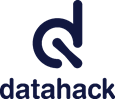